In [54]:
import numpy as np
import pandas as pd
import sqlite3
from lxml import html, etree
import requests
import pandas as pd
import re
from matplotlib import pyplot as plt
import matplotlib

plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

### Create tables for database

In [4]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [5]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [409]:
conn = create_connection('room8.db')

In [410]:
sql_command = '''CREATE TABLE IF NOT EXISTS User (
  id INT NOT NULL,
  firstName VARCHAR(255),
  lastName VARCHAR(255),
  neighborhoodId INT,
  PRIMARY KEY (id)
);'''
create_table(conn, sql_command)
sql_command = '''CREATE TABLE IF NOT EXISTS Neighborhood(
  id INT NOT NULL,
  name VARCHAR(255), 
  metro VARCHAR(255),
  PRIMARY KEY (id) 
);'''
create_table(conn, sql_command)
sql_command = '''CREATE TABLE IF NOT EXISTS User_Neighborhood(
  id int(10) NOT NULL,
  userID int(10) NOT NULL,
  neighborhoodId int(10) NOT NULL, 
  PRIMARY KEY(id),
  FOREIGN KEY (userID) REFERENCES User (id),
  FOREIGN KEY (neighborhoodId) REFERENCES Neighborhood (id) 
);'''
create_table(conn, sql_command)
conn.commit()
conn.close()

### Scrape some neighborhood data from Wikipedia

In [411]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco')
tree = html.fromstring(page.content)

In [412]:
neighborhoods = tree.xpath('/html/body/div[3]/div[3]/div[4]/div/div[2]/div/ul')

In [413]:
neighborhoodArray = neighborhoods[0].text_content().split('\n')

In [414]:
SF = [neighborhood + ['San Francisco'] for neighborhood in [[i.split(' ',1)[1]] for i in neighborhoodArray if len(i) > 0][:-4]]

In [415]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Oakland,_California')
tree = html.fromstring(page.content)

In [416]:
neighborhoods = tree.xpath('/html/body/div[3]/div[3]/div[4]/div/ul/li')

In [417]:
Oakland = [neighborhood + ['Oakland'] for neighborhood in [i.text_content().split(',') for i in neighborhoods] if neighborhood[0] != '']

In [418]:
neighborhoodList = SF + Oakland
neighborhoodList = [[str(i+1)] + neighborhoodList[i] for i in range(0,len(neighborhoodList))]

### Functions to convert to string for sqlfiddle to take in.
Due to storage constraints on SQLfiddle only use a random sample of the neighborhoods and small sample for users.

In [419]:
def convertDataListToString(TableType, Data):
    if TableType == 'Neighborhood':
        stringVec = ["({id}, '{name}', '{metro}')".format(id=row[0], name=row[1], metro=row[2]) for row in Data]
    elif TableType == 'User':
        stringVec = ["({id}, '{firstName}','{lastName}', {neighborhoodId})".format(id=row[0], firstName=row[1], lastName=row[2], neighborhoodId=row[3]) for row in Data]
    else:
        stringVec = ["({id}, {userId}, {neighborhoodId})".format(id=row[0], userId=row[1], neighborhoodId=row[2]) for row in Data]
    return(stringVec)

def generateRandomDataForSQLFiddle(TableType, TableSize, Data):
    randomData = np.random.choice(convertDataListToString(TableType, Data),
                 size = TableSize, replace = False, p = None)
    if TableType == 'Neighborhood':
        sqlCommand = "INSERT INTO Neighborhood (id, name, metro) VALUES" + ','.join(randomData) + ';'
        return(sqlCommand)
    elif TableType == 'User':
        sqlCommand1 = "INSERT INTO User (id, firstName, lastName, neighborhoodId) VALUES" + ','.join(randomData) + ';'
        tmp = [re.sub('[(),]','',i).split(' ') for i in randomData ]
        UserNeighborhoodData = [[i+1, tmp[i][0], tmp[i][-1]]for i in range(0, len(tmp))]
        sqlCommand2 = "INSERT INTO User_Neighborhood (id, userId,neighborhoodId) VALUES" + ','.join(convertDataListToString('UserNeighborhood',  UserNeighborhoodData))
        return(sqlCommand1, sqlCommand2)        

In [420]:
tmp = generateRandomDataForSQLFiddle('Neighborhood',40, neighborhoodList)

In [421]:
tmp

"INSERT INTO Neighborhood (id, name, metro) VALUES(1, 'Alamo Square', 'San Francisco'),(194, 'Merriwood', 'Oakland'),(73, 'Mission Terrace', 'San Francisco'),(78, 'North Beach', 'San Francisco'),(102, 'South of Market', 'San Francisco'),(137, 'Maxwell Park', 'Oakland'),(166, 'Lake Merritt (the body of water)', 'Oakland'),(103, 'South Park', 'San Francisco'),(70, 'Mission Bay', 'San Francisco'),(150, 'Meadow Brook', 'Oakland'),(24, 'Diamond Heights', 'San Francisco'),(34, 'Fisherman's Wharf', 'San Francisco'),(10, 'Buena Vista', 'San Francisco'),(192, 'Hiller Highlands', 'Oakland'),(202, 'Lake Temescal', 'Oakland'),(145, 'Reservoir Hill', 'Oakland'),(68, 'Mid-Market', 'San Francisco'),(132, 'Laurel', 'Oakland'),(49, 'Japantown', 'San Francisco'),(193, 'Glen Highlands', 'Oakland'),(71, 'Mission District', 'San Francisco'),(51, 'Laguna Honda', 'San Francisco'),(197, 'Forestland', 'Oakland'),(11, 'Butchertown (Old and New)', 'San Francisco'),(54, 'Lakeshore', 'San Francisco'),(79, 'North o

In [422]:
tmp1 = re.sub("(INSERT INTO Neighborhood \(id, name, metro\) VALUES)","", tmp)
neighborhoodIds = re.sub("[A-z\-\,\'\'\(\)\/;]", '',tmp1).split()

In [423]:
conn = create_connection('room8.db')
c = conn.cursor()
c.executemany('''INSERT OR IGNORE INTO Neighborhood (id, name, metro) VALUES(?,?,?)''', neighborhoodList)
conn.commit()

### Make fake user data

In [424]:
import names;

In [425]:
def generateFakeUserName():
    return([names.get_first_name(), names.get_last_name()])
def generateFakeUser(numUsers, neighborhoodData):
    locationData = np.random.choice(neighborhoodData, size = numUsers+1, replace = True, p = None)
    userTable = [[i+1] + generateFakeUserName() + [locationData[i]] for i in range(0,numUsers)]
    return(userTable)

In [426]:
userList = generateFakeUser(100, neighborhoodIds)

In [427]:
c.executemany('''INSERT OR IGNORE INTO User (id, firstName, lastName, neighborhoodId) VALUES(?,?,?,?)''', userList)
conn.commit()

In [428]:
[a,b] = generateRandomDataForSQLFiddle('User',25, userList)

In [429]:
a

"INSERT INTO User (id, firstName, lastName, neighborhoodId) VALUES(84, 'John','Obryan', 146),(51, 'Cheryl','Larson', 92),(99, 'Cameron','Borders', 54),(38, 'Chad','Carroll', 197),(97, 'Elizabeth','Brown', 143),(98, 'Susan','Hoey', 151),(12, 'Elizabeth','Winebarger', 54),(45, 'Lillian','Brown', 30),(3, 'Ashley','Illsley', 92),(87, 'Kevin','Maxfield', 10),(75, 'Ashley','Ackley', 93),(27, 'Ryan','Hites', 215),(23, 'Ora','Vang', 146),(8, 'Joanne','Hahn', 28),(20, 'Patricia','Wheeler', 103),(11, 'Cecila','Nelson', 166),(70, 'Bruce','Elliott', 103),(16, 'Wiley','Jones', 28),(59, 'Regina','Rogers', 73),(25, 'Esther','Veach', 34),(21, 'Gene','Sneed', 193),(5, 'Adeline','Cruce', 79),(33, 'Ken','Martin', 102),(95, 'Anthony','Garcia', 151),(30, 'Ruth','Kondo', 70);"

In [430]:
b

'INSERT INTO User_Neighborhood (id, userId,neighborhoodId) VALUES(1, 84, 146),(2, 51, 92),(3, 99, 54),(4, 38, 197),(5, 97, 143),(6, 98, 151),(7, 12, 54),(8, 45, 30),(9, 3, 92),(10, 87, 10),(11, 75, 93),(12, 27, 215),(13, 23, 146),(14, 8, 28),(15, 20, 103),(16, 11, 166),(17, 70, 103),(18, 16, 28),(19, 59, 73),(20, 25, 34),(21, 21, 193),(22, 5, 79),(23, 33, 102),(24, 95, 151),(25, 30, 70)'

### Create UserNeighborhood using User Data

In [435]:
UserNeighborhoodList = [[i + 1, userList[i][0], userList[i][-1]] for i in range(0, len(userList))]

In [438]:
c.executemany('''INSERT OR IGNORE INTO User_Neighborhood (id, userId, neighborhoodId) VALUES(?,?,?)''', UserNeighborhoodList)

In [439]:
conn.close()

### Exploration with the Database

In [61]:
conn = create_connection('room8.db')
c = conn.cursor()

In [62]:
# Examine how many users are in each neighborhood
c.execute('''SELECT COUNT(id), name, metro FROM User LEFT JOIN 
(SELECT id neighborhoodId, name, metro FROM Neighborhood) Neighborhood USING(neighborhoodId) GROUP BY(neighborhoodId) 
ORDER BY COUNT(id) DESC''')

In [63]:
result = c.fetchall()

In [64]:
result = pd.DataFrame(result, columns=['Count','Neighborhood','Metro'])

Text(0.5,1,'User Count By Metro Sorted Descending')

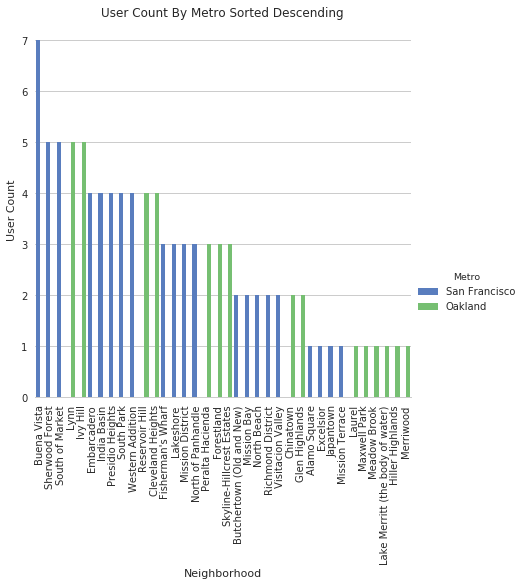

In [69]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="Neighborhood", y="Count", hue="Metro", data=result,
                   size=6, kind="bar", palette="muted")
g.set_xticklabels(rotation=90)
g.despine(left=True)
g.set_ylabels("User Count")
plt.title('User Count By Metro Sorted Descending')